# Fly on ball: minimal examples
### This notebook contains two examples:
1. Loading and manipulating the fly model directly, without setting up a full RL environment.
2. Creating full ready-to-train RL environment for a simple fly-on-ball task. The task is to get the fly to rotate the ball at certain speed.

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import PIL.ImageDraw

from dm_control import mujoco
from dm_control import mjcf
from dm_control.mujoco.wrapper.mjbindings import enums

from flybody.fly_envs import walk_on_ball
from flybody.utils import display_video
from flybody.tasks.task_utils import retract_wings

# 1. Load fly model directly and make modifications to it:
* Weld fly model to world (to emulate tethered fly)
* Add ball
* Remove "surprising collisions" between thorax and its immediate children.

For details on programmatic model manipulations with PyMJCF, see https://github.com/google-deepmind/dm_control/blob/main/dm_control/mjcf/README.md

In [9]:
# Load model (as mjcf model).
xml_path = 'path/to/fruitfly.xml'

mjcf_model = mjcf.from_path(xml_path)

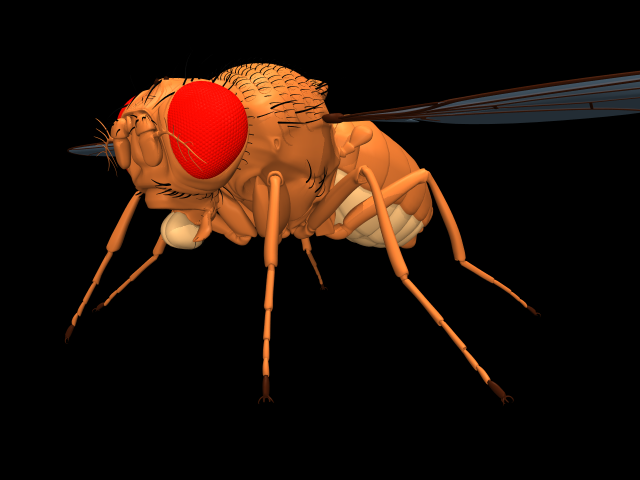

In [11]:
# Visualize fly as loaded.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)

pixels = physics.render(camera_id=0, width=640, height=480)
PIL.Image.fromarray(pixels)

In [12]:
# Load model (again, just in case) and make modifications to it.

mjcf_model = mjcf.from_path(xml_path)

# Add texture and material for ball.
texture = mjcf_model.asset.add('texture', rgb1=[.2, .3, .4], rgb2=[.1, .2, .3],
                               type='2d', builtin='checker', name='groundplane',
                               width=200, height=200,)
material = mjcf_model.asset.add('material', name='ballsurface', 
                                texrepeat=[2, 2],  # Makes white squares exactly 1x1 length units.
                                texuniform=False,
                                reflectance=0.2,
                                texture=texture)

# Remove freejoint.
freejoint = mjcf_model.find('joint', 'free')
if freejoint is not None:
    freejoint.remove()
    
# == Add ball.
radius = 0.454  # Pick ball radius.
# Calculate ball position wrt fly given ball radius.
claw_T1_left = np.array([0.09178167, 0.08813114, -0.12480448])
ball_x = - 0.05
ball_z = - np.sqrt(radius**2 
                   - (claw_T1_left[0] - ball_x)**2 
                   - claw_T1_left[1]**2) + claw_T1_left[2]
ball = mjcf_model.worldbody.add('body', name='ball', pos=(ball_x, 0, ball_z))
ball.add('geom', type='sphere', size=(radius, 0, 0),
         material=material, density=0.01)  # Density of water in cgs == 1.
ball_joint = ball.add('joint', name='ball', type='ball')

# Exclude "surprising collisions".
for child in mjcf_model.find('body', 'thorax').all_children():
    if child.tag == 'body':
        mjcf_model.contact.add('exclude', name=f'thorax_{child.name}',
                               body1='thorax', body2=child.name)

In [13]:
# Sanity check, should be equal to ball radius selected above.
np.sqrt((ball_z - claw_T1_left[2])**2 
        + (ball_x - claw_T1_left[0])**2 
        + claw_T1_left[1]**2)

0.45400000000000007

In [14]:
# Compile modified model.
physics = mjcf.Physics.from_mjcf_model(mjcf_model)

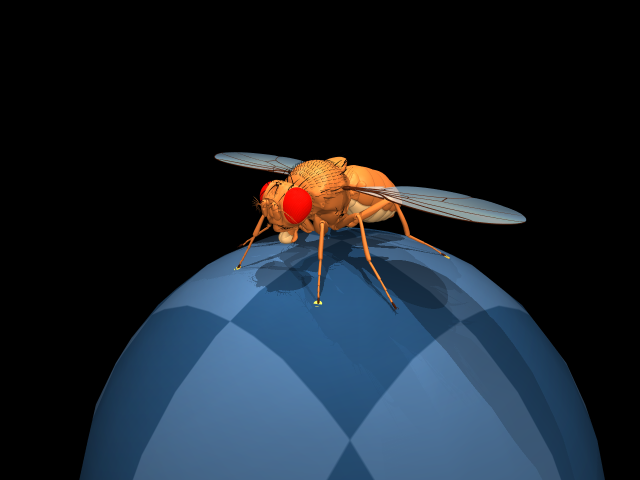

In [15]:
# Visualize new modified fly model on ball.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_CONTACTPOINT] = True  # Flag to show contacts.

pixels = physics.render(camera_id=1, width=640, height=480,
                        scene_option=scene_option)
PIL.Image.fromarray(pixels)

# Run small simulation: move legs randomly and make video

In [16]:
# Get indices for leg actuators (to avoid moving the entire body).
act_indices = []
for i in range(physics.model.nu):
    name = physics.model.id2name(i, 'actuator')
    if 'coxa' in name or 'femur' in name or 'tibia' in name or 'tarsus' in name:
        act_indices.append(i)

In [17]:
# Run simulation and make video.

# Set initial state.
with physics.reset_context():
    # Initial ball velocioty.
    physics.named.data.qvel['ball'] = [0, -2., 0]
    retract_wings(physics, prefix='')

# Run simulation.
timestep_ratio = 10
n_act = len(act_indices)
frames = []
for i in range(2000):
    if i % timestep_ratio == 0:
        action = np.random.uniform(-0.5, 0.5, size=n_act)
        physics.data.ctrl[act_indices] = action
        pixels = physics.render(camera_id=1, width=640, height=480, 
                                scene_option=scene_option)
        frames.append(pixels)
    physics.step()


In [18]:
display_video(frames)

# 2. Create full RL environment for fly-on-ball task
Interaction with RL environments is simple, see https://github.com/google-deepmind/dm_env/blob/master/docs/index.md

In [19]:
# Create RL environment.
env = walk_on_ball()

In [ ]:
# Examine RL environment: observations.
env.observation_spec()

In [ ]:
# Examine RL environment: actions.
env.action_spec()

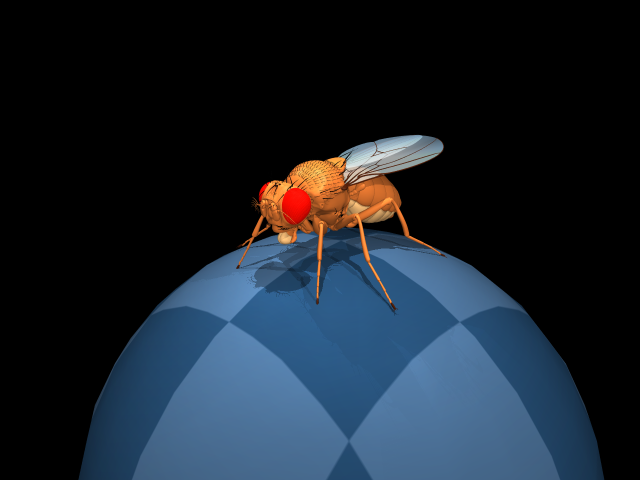

In [23]:
# Reset and visualize the initial state of episode.
timestep = env.reset()

pixels = env.physics.render(camera_id=1, width=640, height=480)
PIL.Image.fromarray(pixels)

In [ ]:
# `timestep` contains the current step_type, reward, discount, observation.
timestep

# Run short episode with random actions and make video

In [25]:
timestep = env.reset()
action_size = env.action_spec().shape

frames = []
for _ in range(400):
    frames.append(env.physics.render(camera_id=1, width=640, height=480))
    # Select random actions. However, normally this line will instead be:
    # action = policy(timestep.observation)
    action = np.random.uniform(-0.3, 0.3, size=action_size)
    timestep = env.step(action)

In [26]:
display_video(frames)